In [1]:
# ## install finrl library
!pip install wrds
!pip install swig

!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.16
    Uninstalling SQLAlchemy-2.0.16:
      Successfully uninstalled SQLAlchemy-2.0.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:00
Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-glx_21.2.6-0ubuntu0.1~20.04.2_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (21.2.6-0ubuntu0.1~20.04.2) ...
Selecting previously unselected package swig4.0.
Preparing to unpack .../swig4.0_4.0.1-5build1_amd64.deb ...
Unpacking swig4.0 (4.0.1-5build1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.1-5build1_all.deb ...
Unpacking swig (4.0.1-5build1) ...
Setting up libgl1-mesa-glx:am

In [2]:
!pip install -r requirements.txt
!pip install SQLAlchemy==1.4.46

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.48
    Uninstalling SQLAlchemy-1.4.48:
      Successfully uninstalled SQLAlchemy-1.4.48


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11
/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# instantiate train/test date
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-03'

In [7]:
print(TEST_START_DATE,TEST_END_DATE)

2020-08-01 2021-10-01


In [8]:
# preprocess
import yfinance as yf

ticker = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
stocks = yf.download(ticker, start = TRAIN_START_DATE, end = TRADE_END_DATE )

df =  YahooDownloader(start_date = TRAIN_START_DATE,
                      end_date = TRADE_END_DATE,
                      ticker_list = ticker).fetch_data()

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30195, 8)


In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.364521,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.793037,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.110189,8449400,XLK,0


In [10]:
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3354, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
processed.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364521,7567500,XLB,0,0.0,25.521513,25.289543,100.0,66.666667,100.0,25.364521,25.364521,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,37.747688,16928400,XLE,0,0.0,25.521513,25.289543,100.0,66.666667,100.0,37.747688,37.747688,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0,0.0,25.521513,25.289543,100.0,66.666667,100.0,9.344017,9.344017,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.793037,7471500,XLI,0,0.0,25.521513,25.289543,100.0,66.666667,100.0,21.793037,21.793037,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.110189,8449400,XLK,0,0.0,25.521513,25.289543,100.0,66.666667,100.0,19.110189,19.110189,20.040001,0.0


In [12]:
list_ticker = processed["tic"].unique().tolist() # ticker list
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

process_full = pd.DataFrame(combination, columns=['date','tic']).merge(processed, on=['date','tic'],how='left')
process_full = process_full[process_full['date'].isin(processed['date'])]
process_full = process_full.sort_values(['date','tic'])

process_full = process_full.fillna(0)

mvo_df = process_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
mvo_df.head(10) # 종가만

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,close
0,2010-01-04,XLB,25.364521
1,2010-01-04,XLE,37.747688
2,2010-01-04,XLF,9.344017
3,2010-01-04,XLI,21.793037
4,2010-01-04,XLK,19.110189
5,2010-01-04,XLP,18.586603
6,2010-01-04,XLU,19.326466
7,2010-01-04,XLV,25.110273
8,2010-01-04,XLY,25.176525
9,2010-01-05,XLB,25.446535


In [13]:
process_full.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364521,7567500.0,0.0,0.0,25.521513,25.289543,100.0,66.666667,100.0,25.364521,25.364521,20.040001,0.0
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747688,16928400.0,0.0,0.0,25.521513,25.289543,100.0,66.666667,100.0,37.747688,37.747688,20.040001,0.0
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.0,25.521513,25.289543,100.0,66.666667,100.0,9.344017,9.344017,20.040001,0.0
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793037,7471500.0,0.0,0.0,25.521513,25.289543,100.0,66.666667,100.0,21.793037,21.793037,20.040001,0.0
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110189,8449400.0,0.0,0.0,25.521513,25.289543,100.0,66.666667,100.0,19.110189,19.110189,20.040001,0.0


In [14]:
# data split
train = data_split(process_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(process_full, TRADE_START_DATE, TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3573


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Env


## Overview

State Space = [p,h,b]. stock price p, stock shares h, remaining balance b

Action Space = [sell, buy] (hold action realized by remaining balance )

Reward : Change of pf value (depending on a,s,s')

Policy

Value function

Action function

Reward Hypothesis? Maximize pf value


## Env Setting

State Space : 8(INDICATORS) * 9(NUMBER of stocks) + 2(stock price p, stock shares h) * 9(NUMBER of stocks) + 1(remaining balance b)

1. Balance b : 현금계좌 잔고

2. Stock price : p

3. Shares : 보유량

---

4. MACD : SMA - LMA, signal = rolling by k days (closed price)

5. CCI : 주가가 MA에서 얼마나 떨어져 있는지 (과매수, 과매도 측정)

6. ADX : 추세의 강도를 측정

7. RSI

8. Bollinger band

Action Space : (2k+1)^9, k <= h_max (h_max는 사용자 설정 hp)

{-k,...,-1,0,1,...,k}

hmax : 한번에 살수있는 주식의 최대 share

In [15]:
INDICATORS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

Stock Dimension: 9, State Space: 91


In [17]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

TD3_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }
SAC_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'td3' : 10_000,
                 'sac' : 10_000
                 }

In [18]:
# DRL models from Stable Baselines 3
from __future__ import annotations

import time

import numpy as np
import pandas as pd
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True


class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        #         state_memory=[] #add memory pool to store states
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets


class DRLEnsembleAgent:
    @staticmethod
    def get_model(
        model_name,
        env,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        seed=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[
                temp_model_kwargs["action_noise"]
            ](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(temp_model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **temp_model_kwargs,
        )

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        model.save(
            f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps // 1000}k_{iter_num}"
        )
        return model

    @staticmethod
    def get_validation_sharpe(iteration, model_name):
        """Calculate Sharpe ratio based on validation results"""
        df_total_value = pd.read_csv(
            f"results/account_value_validation_{model_name}_{iteration}.csv"
        )
        # If the agent did not make any transaction
        if df_total_value["daily_return"].var() == 0:
            if df_total_value["daily_return"].mean() > 0:
                return np.inf
            else:
                return 0.0
        else:
            return (
                (4**0.5)
                * df_total_value["daily_return"].mean()
                / df_total_value["daily_return"].std()
            )

    def __init__(
        self,
        df,
        train_period,
        val_test_period,
        rebalance_window,
        validation_window,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        print_verbosity,
    ):
        self.df = df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[
            (df.date > val_test_period[0]) & (df.date <= val_test_period[1])
        ].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity

    def DRL_validation(self, model, test_data, test_env, test_obs):
        """validation process"""
        for _ in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(
        self, model, name, last_state, iter_num, turbulence_threshold, initial
    ):
        """make a prediction based on trained model"""

        ## trading env
        trade_data = data_split(
            self.df,
            start=self.unique_trade_date[iter_num - self.rebalance_window],
            end=self.unique_trade_date[iter_num],
        )
        trade_env = DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=trade_data,
                    stock_dim=self.stock_dim,
                    hmax=self.hmax,
                    initial_amount=self.initial_amount,
                    num_stock_shares=[0] * self.stock_dim,
                    buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                    sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                    reward_scaling=self.reward_scaling,
                    state_space=self.state_space,
                    action_space=self.action_space,
                    tech_indicator_list=self.tech_indicator_list,
                    turbulence_threshold=turbulence_threshold,
                    initial=initial,
                    previous_state=last_state,
                    model_name=name,
                    mode="trade",
                    iteration=iter_num,
                    print_verbosity=self.print_verbosity,
                )
            ]
        )

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.envs[0].render()

        df_last_state = pd.DataFrame({"last_state": last_state})
        # 수정(06/28): run_ensemble_strategy 실행시 ValueError: If using all scalar values, you must pass an index 오류 출력됨.
        # 수정: df_last_state가 run_ensemble_strategy를 시행하는데 있어서 쓰이지 않음. 따라서 제거해주고 시행해봄. 그 결과 동일한 오류 발생
        df_last_state.to_csv(f"results/last_state_{name}_{i}.csv", index=False)
        # 수정 : 다시 풀어줌. requirements.txt issue인게 밝혀짐.
        # 수정 : last_state = trade_env.render() --> trade_env.evns[0].render() 로 바꿔줌
        return last_state

    def run_ensemble_strategy_(
        self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, TD3_model_kwargs, SAC_model_kwargs, timesteps_dict
    ):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []
        td3_sharpe_list = []
        sac_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[
            (self.df.date < self.train_period[1])
            & (self.df.date >= self.train_period[0])
        ]
        insample_turbulence_threshold = np.quantile(
            insample_turbulence.turbulence.values, 0.90
        )

        start = time.time()
        for i in range(
            self.rebalance_window + self.validation_window,
            len(self.unique_trade_date),
            self.rebalance_window,
        ):
            validation_start_date = self.unique_trade_date[
                i - self.rebalance_window - self.validation_window
            ]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[
                self.df["date"]
                == self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ]
            ].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[
                start_date_index : (end_date_index + 1), :
            ]

            historical_turbulence = historical_turbulence.drop_duplicates(
                subset=["date"]
            )

            historical_turbulence_mean = np.mean(
                historical_turbulence.turbulence.values
            )

            # print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(
                    insample_turbulence.turbulence.values, 1
                )

            turbulence_threshold = np.quantile(
                insample_turbulence.turbulence.values, 0.99
            )
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup starts ##############
            ## training env
            train = data_split(
                self.df,
                start=self.train_period[0],
                end=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            self.train_env = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=train,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )

            validation = data_split(
                self.df,
                start=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
                end=self.unique_trade_date[i - self.rebalance_window],
            )
            ############## Environment Setup ends ##############

            ############## Training and Validation starts ##############
            print(
                "======Model training from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model(
                "a2c", self.train_env, policy="MlpPolicy", model_kwargs=A2C_model_kwargs
            )
            model_a2c = self.train_model(
                model_a2c,
                "a2c",
                tb_log_name=f"a2c_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["a2c"],
            )  # 100_000

            print(
                "======A2C Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_a2c = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="A2C",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(
                model=model_a2c,
                test_data=validation,
                test_env=val_env_a2c,
                test_obs=val_obs_a2c,
            )
            sharpe_a2c = self.get_validation_sharpe(i, model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model(
                "ppo", self.train_env, policy="MlpPolicy", model_kwargs=PPO_model_kwargs
            )
            model_ppo = self.train_model(
                model_ppo,
                "ppo",
                tb_log_name=f"ppo_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ppo"],
            )  # 100_000
            print(
                "======PPO Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ppo = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="PPO",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(
                model=model_ppo,
                test_data=validation,
                test_env=val_env_ppo,
                test_obs=val_obs_ppo,
            )
            sharpe_ppo = self.get_validation_sharpe(i, model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model(
                "ddpg",
                self.train_env,
                policy="MlpPolicy",
                model_kwargs=DDPG_model_kwargs,
            )
            model_ddpg = self.train_model(
                model_ddpg,
                "ddpg",
                tb_log_name=f"ddpg_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ddpg"],
            )  # 50_000
            print(
                "======DDPG Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ddpg = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="DDPG",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(
                model=model_ddpg,
                test_data=validation,
                test_env=val_env_ddpg,
                test_obs=val_obs_ddpg,
            )
            sharpe_ddpg = self.get_validation_sharpe(i, model_name="DDPG")

            print("======SAC Training========")
            model_sac = self.get_model(
                "sac", self.train_env, policy="MlpPolicy", model_kwargs=SAC_model_kwargs
            )
            model_sac = self.train_model(
                model_sac,
                "sac",
                tb_log_name=f"sac_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["sac"],
                # 100_000
            )

            print(
                "======SAC Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_sac = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="SAC",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_sac = val_env_sac.reset()
            self.DRL_validation(
                model=model_sac,
                test_data=validation,
                test_env=val_env_sac,
                test_obs=val_obs_sac,
            )
            sharpe_sac = self.get_validation_sharpe(i, model_name="SAC")
            print("SAC Sharpe Ratio : ", sharpe_sac)

            print("======TD3 Training========")
            model_td3 = self.get_model(
                "td3", self.train_env, policy="MlpPolicy", model_kwargs=TD3_model_kwargs
            )
            model_td3 = self.train_model(
                model_td3,
                "td3",
                tb_log_name=f"td3_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["td3"],
                # 100_000
            )

            print(
                "======TD3 Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_td3 = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="TD3",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_td3 = val_env_td3.reset()
            self.DRL_validation(
                model=model_td3,
                test_data=validation,
                test_env=val_env_td3,
                test_obs=val_obs_td3,
            )
            sharpe_td3 = self.get_validation_sharpe(i, model_name="TD3")
            print("TD3 Sharpe Ratio : ", sharpe_td3)

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)
            sac_sharpe_list.append(sharpe_sac)
            td3_sharpe_list.append(sharpe_td3)

            print(
                "======Best Model Retraining from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[i - self.rebalance_window],
            )
            # Environment setup for model retraining up to first trade date
            # train_full = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window])
            # self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                                    self.stock_dim,
            #                                                    self.hmax,
            #                                                    self.initial_amount,
            #                                                    self.buy_cost_pct,
            #                                                    self.sell_cost_pct,
            #                                                    self.reward_scaling,
            #                                                    self.state_space,
            #                                                    self.action_space,
            #                                                    self.tech_indicator_list,
            #                                                    print_verbosity=self.print_verbosity)])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg) & (sharpe_ppo >= sharpe_sac) & (sharpe_ppo >= sharpe_td3):
                model_use.append("PPO")
                model_ensemble = model_ppo

                # model_ensemble = self.get_model("ppo",self.train_full_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg) & (sharpe_a2c >= sharpe_sac) & (sharpe_a2c >= sharpe_td3):
                model_use.append("A2C")
                model_ensemble = model_a2c

                # model_ensemble = self.get_model("a2c",self.train_full_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000
            elif (sharpe_ddpg > sharpe_ppo) & (sharpe_ddpg > sharpe_a2c) & (sharpe_ddpg >= sharpe_sac) & (sharpe_ddpg >= sharpe_td3):
                model_use.append("DDPG")
                model_ensemble = model_ddpg

                # model_ensemble = self.get_model("ddpg",self.train_full_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg']) #50_000#

            elif (sharpe_sac > sharpe_ppo) & (sharpe_sac > sharpe_a2c) & (sharpe_sac >= sharpe_ddpg) & (sharpe_sac >= sharpe_td3):
                model_use.append("SAC")
                model_ensemble = model_sac

            else:
                model_use.append("TD3")
                model_ensemble = model_td3
            ############## Training and Validation ends ##############

            ############## Trading starts ##############
            print(
                "======Trading from: ",
                self.unique_trade_date[i - self.rebalance_window],
                "to ",
                self.unique_trade_date[i],
            )
            # print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(
                model=model_ensemble,
                name="ensemble",
                last_state=last_state_ensemble,
                iter_num=i,
                turbulence_threshold=turbulence_threshold,
                initial=initial,
            )
            ############## Trading ends #############

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame(
            [
                iteration_list,
                validation_start_date_list,
                validation_end_date_list,
                model_use,
                a2c_sharpe_list,
                ppo_sharpe_list,
                ddpg_sharpe_list,
                sac_sharpe_list,
                td3_sharpe_list
            ]
        ).T
        df_summary.columns = [
            "Iter",
            "Val Start",
            "Val End",
            "Model Used",
            "A2C Sharpe",
            "PPO Sharpe",
            "DDPG Sharpe",
            "SAC Sharpe",
            "TD3 Sharpe"
        ]

        return df_summary


In [19]:
DRLEnsembleAgent.run_ensemble_strategy_

<function __main__.DRLEnsembleAgent.run_ensemble_strategy_(self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, TD3_model_kwargs, SAC_model_kwargs, timesteps_dict)>

In [20]:
rebalance_window = 63 # number of days to retrain the model
validation_window = 63 # number of days to do validation

ensemble_agent = DRLEnsembleAgent(df=processed,
                                train_period = (TRAIN_START_DATE, TRAIN_END_DATE),
                                val_test_period = (TRADE_START_DATE, TRADE_END_DATE),
                                rebalance_window=rebalance_window,
                                validation_window=validation_window,
                                **env_kwargs )

여기서 말하는 validation test period가 test period임. 우리가 설정해놓은 TRADE_START_DATE, TRADE_END_DATE.

In [21]:
# df_summary = ensemble_agent.run_ensemble_strategy_(A2C_model_kwargs,
#                                                  PPO_model_kwargs,
#                                                  DDPG_model_kwargs,
#                                                  timesteps_dict)

![image.png](attachment:image.png)

오류 fix

해당 issue에 대해 대처하는 방법 두가지
1. source_code들어가서 필요하지 않은 부분 제거함
2. requirements issue 로 발생함.

다음 명령으로 손쉽게 requirements.txt 생성이 가능함
$ pip freeze > requirements.txt

다음 명령을 실행하면 모든 패키지를 한번에 설치해준다.
$ pip install -r requirements.txt

In [22]:
df_summary = ensemble_agent.run_ensemble_strategy_(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  52.59992157661331
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
--------------------------------------
| time/                 |            |
|    fps                | 187        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.8      |
|    explained_variance | -0.0999    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -20.1      |
|    reward             | 0.37920728 |
|    std                | 1          |
|    value_loss         | 4.78       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps   

In [23]:
df_summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-10-04,2022-01-03,DDPG,0.150872,0.219682,0.396476,0.230153,0.277043
1,189,2022-01-03,2022-04-04,SAC,-0.20745,-0.198411,-0.185616,-0.165902,-0.261548
2,252,2022-04-04,2022-07-06,A2C,-0.329583,-0.370296,-0.336571,-0.348207,-0.374721
3,315,2022-07-06,2022-10-04,TD3,-0.242338,-0.259549,-0.252698,-0.256672,-0.218958
4,378,2022-10-04,2023-01-04,SAC,-0.009285,0.031413,0.184959,0.237765,0.087733


# Backtest

In [33]:
unique_trade_date = processed[(processed.date > TRADE_START_DATE)&(processed.date <= TRADE_END_DATE)].date.unique()


In [34]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.766982707755714


In [35]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999899.296218,2022-01-04,-0.000101,2022-01-04
2,998404.147927,2022-01-05,-0.001495,2022-01-05
3,997452.720067,2022-01-06,-0.000953,2022-01-06
4,996484.292585,2022-01-07,-0.000971,2022-01-07


<Axes: >

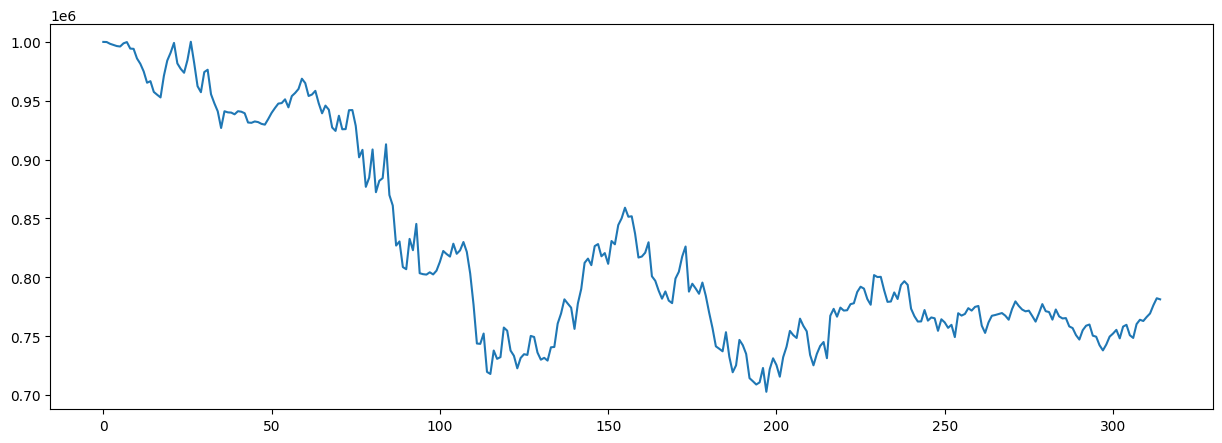

In [36]:
%matplotlib inline
df_account_value.account_value.plot()

In [37]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.179182
Cumulative returns    -0.218717
Annual volatility      0.225101
Sharpe ratio          -0.766983
Calmar ratio          -0.602591
Stability              0.631756
Max drawdown          -0.297353
Omega ratio            0.874355
Sortino ratio         -1.018649
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.910150
Daily value at risk   -0.029045
dtype: float64


In [38]:
# backtest_stats 주소
backtest_stats

<function finrl.plot.backtest_stats(account_value, value_col_name='account_value')>

In [39]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
Annual return         -0.066002
Cumulative returns    -0.081561
Annual volatility      0.188609
Sharpe ratio          -0.269023
Calmar ratio          -0.300816
Stability              0.080948
Max drawdown          -0.219408
Omega ratio            0.956841
Sortino ratio         -0.373593
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.988482
Daily value at risk   -0.023964
dtype: float64


In [40]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")

df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv("df_account_value.csv")

print("df_dji:",df_dji)

df_dji:                      dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2023-03-29  8.942886e+05
2023-03-30  8.981544e+05
2023-03-31  9.095010e+05
2023-04-03  9.184391e+05
2023-04-04           NaN

[315 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date :         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
391  2023-04-25
392  2023-04-26
393  2023-04-27
394  2023-04-28
395  2023-05-01

[396 rows x 1 columns]
df_result_ensemble:                   ensemble
date                      
2022-01-03  1000000.000000
2022-01-04   999899.296218
2022-01-05   998404.147927
2022-01-06   997452.720067
2022-01-07   996484.292585
...                    ...
2023-03-29   766277.605642
2023-03-30   769242.466193
2023-03-31   776279.393640
2023-04-03   782191.503091
2023-04-04   781282.916978

[315 rows x 1 columns]
==============Compare to DJIA===========


<Figure size 1500x500 with 0 Axes>

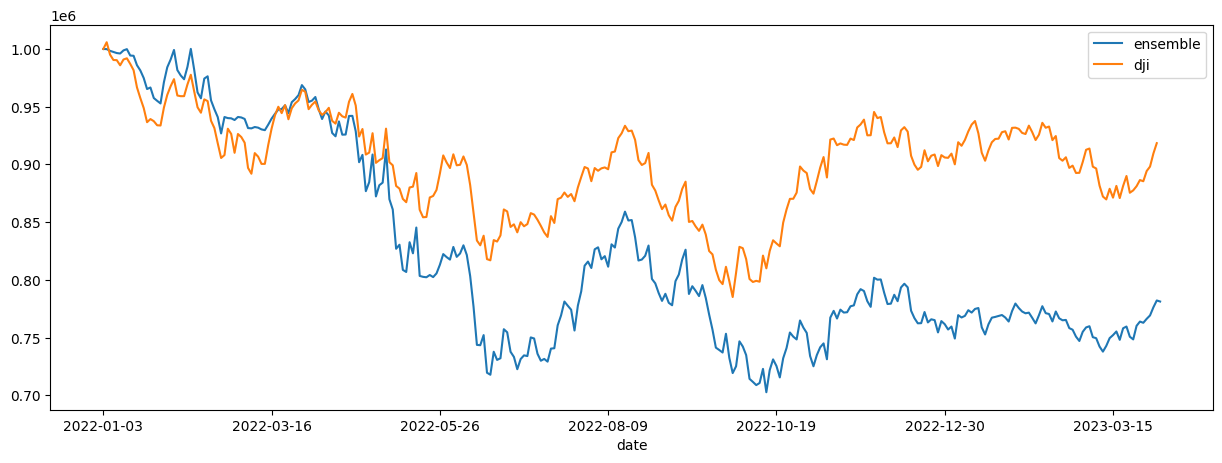

In [41]:
# plot
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date' : df_account_value['date'], 'ensemble' : df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')
print("df_result_ensemble.columns: ", df_result_ensemble.columns)

print("df_trade_date : ", df_trade_date)

df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble:", df_result_ensemble)

print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

# Comments



- test data가 상승장인 경우로 특이한 케이스임. too specific 함. Should we go (1) more general ? Or (2) more specified to certain scenarios ?

- Where does randomness come from?
    - Exploration of policy 인듯. episode도 5개밖에 안되고 training 도 15분 남짓이라 n_step, episode늘려서 더 해봐도 좋은 결과 나올거 같음. 다만 train 에 too dependent 하지 않게. depdendent 하더라도, 그 scenario에 맞다는 걸 검증할 수 있으면 좋을텐데.

    - scenario를 나누고 그에 대해 검증해볼까? 진짜 time series classification?

- SAC랑 TD3에 대해서도 할거임



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
